In [1]:
import pandas as pd

from datetime import datetime
# sys.path.append(os.path.abspath(os.path.join('../src')))  # Adjust as needed

from src.distance_utils import distance
from src.data_load import load_tables, load_artificial_instance
from src.filtering import filter_labors_by_date, filter_labors_by_city, filter_labores
from src.metrics import collect_vt_metrics_range, show_day_report_dayonly, compute_indicators
from src.preprocessing import remap_to_base_date, build_services_map_df, process_group
from src.plotting import plot_weekly_services, plot_daily_services_week
from src.config import *
from src.inst_generation_utils import top_service_days, create_artificial_week

data_path = '../data'
instance = 'inst2'
directorio_df, labors_raw_df, cities_df, duraciones_df, valid_cities = load_tables(data_path,generate_labors=False)

# Combining alfred code with Alfred name

In [8]:
labors_raw_df = labors_raw_df.dropna(subset=['address_point'])
labors_raw_df['longitud'] = labors_raw_df['address_point'].apply(lambda x:  x.strip().replace("POINT (", "").replace(")", "").split()[0])
labors_raw_df['latitud'] = labors_raw_df['address_point'].apply(lambda x:  x.strip().replace("POINT (", "").replace(")", "").split()[1])
labors_cleaned = labors_raw_df.dropna(subset=['alfred']).\
                                            drop_duplicates(['alfred','address_point'])\
                                            [['alfred', 'address_point', 'address_id', 'latitud', 'longitud']].sort_values(['latitud', 'longitud'])

for col in ['latitud', 'longitud']:
    labors_cleaned[col] = labors_cleaned[col].astype(float)

In [9]:
def enhance_directorio_with_alfred_code(directorio_df: pd.DataFrame,
                                        labors_raw_df: pd.DataFrame,
                                        dir_lat_col="latitud", dir_lon_col="longitud",
                                        lab_lat_col="latitud", lab_lon_col="longitud",
                                        alfred_code_col="alfred") -> pd.DataFrame:
    """
    Add 'alfred_code' to directorio_df by matching on exact lat/long with labors_raw_df.
    """

    # Keep only what we need from labors
    labors_sub = labors_raw_df[[lab_lat_col, lab_lon_col, alfred_code_col]].dropna()

    # Merge directly on coordinates
    merged = directorio_df.merge(
        labors_sub.drop_duplicates(),
        left_on=[dir_lat_col, dir_lon_col],
        right_on=[lab_lat_col, lab_lon_col],
        how="left"
    )

    # Clean up duplicate coordinate columns
    merged = merged.drop(columns=[lab_lat_col, lab_lon_col])

    return merged


In [10]:
labors_cleaned

,alfred,address_point,address_id,latitud,longitud
83621,69147.0,POINT (-75.5051041 10.392139),123522.0,10.392139,-75.505104
5040,14946.0,POINT (-74.79419462825471 10.906019892143393),56474.0,10.906020,-74.794195
92288,71852.0,POINT (-74.7938234 10.9313923),130778.0,10.931392,-74.793823
9,892.0,POINT (-74.80800339999999 11.0228323),56469.0,11.022832,-74.808003
31001,46486.0,POINT (-76.5654636 3.3676395),72449.0,3.367640,-76.565464
...,...,...,...,...,...
78,9478.0,POINT (-75.5644897 6.335345299999999),14932.0,6.335345,-75.564490
86152,70424.0,POINT (-75.560277 6.340593500000001),126965.0,6.340594,-75.560277
10450,22162.0,POINT (-75.56360339999999 6.347043299999999),29508.0,6.347043,-75.563603
23435,26355.0,POINT (-73.0492968 6.9751816),35931.0,6.975182,-73.049297


In [12]:
enhance_directorio_with_alfred_code(directorio_df, labors_cleaned)

,ALFRED'S,DIRECCION,UBICACION,LOCALIDAD,CIUDAD,city,start_time,end_time,alfred
0,Cesar Augusto Enciso,Cl. 44 Sur #72u-25,https://maps.app.goo.gl/4umgXouHXbeShQXz7,Timiza,Bogotá,BOGOTA,07:00:00,17:00:00,NaN
1,Jorge Cortes Rojas,Calle 39 sur # 72m - 26,https://goo.gl/maps/nQdfNYAHqiyzhX768,Timiza,Bogotá,BOGOTA,07:00:00,17:00:00,NaN
2,Mauricio Gomez Pachon,Calle 4b # 8b - 45,https://goo.gl/maps/DF3fav585mxwcEqD9,Cajica,Cajica,BOGOTA,08:00:00,18:00:00,NaN
3,Orlando Jacinto,Calle 86 # 95d - 03,https://goo.gl/maps/h2ZTa92BKkg5NSHUA,Quirigua,Bogotá,BOGOTA,08:00:00,18:00:00,NaN
4,Alberto Mora,Calle 162 #95-24,https://goo.gl/maps/Cy2azZpNRe2tWQRZ6,Suba,Bogotá,BOGOTA,07:00:00,17:00:00,NaN
5,Jhon Fredy Grajales,Carrera 147a # 142 - 30,https://goo.gl/maps/EqMaNJZVF6KcMWEm6,Suba,Bogotá,BOGOTA,08:00:00,18:00:00,10500.0
6,Manuel Romero,Carrera 93 B # 132 - 14,https://goo.gl/maps/oNCnFwdCSUa4H6hD8,Suba,Bogotá,BOGOTA,07:00:00,17:00:00,NaN
7,Yeisson Beltran Garzon,Calle 67 # 7 - 20,https://goo.gl/maps/i9HU3dnkivccKNPP8,Chapinero,Bogotá,BOGOTA,08:00:00,18:00:00,NaN
8,Wilson Socha Cantor,Carrera 18m # 10 - 51,https://goo.gl/maps/gMfLhK6B2eYB95VA7,Soacha,Soacha,BOGOTA,07:00:00,17:00:00,2331.0
9,Javier Barragán,Carrera 1 #32a -20 sur,https://goo.gl/maps/n6xRF4i6eBA7o2Z3A,Soacha,Soacha,BOGOTA,08:00:00,18:00:00,NaN


# Número de servicios por ciudad

## Semanal

/Users/juanbeta/Library/CloudStorage/GoogleDrive-juan.beta98@gmail.com/My Drive/Work/Alfred/Alfred/code/src/plotting.py:355: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_unique["week"] = df_unique[date_col].dt.to_period("W").apply(lambda r: r.start_time)
/Users/juanbeta/Library/CloudStorage/GoogleDrive-juan.beta98@gmail.com/My Drive/Work/Alfred/Alfred/code/src/plotting.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["week"] = df_unique[date_col].dt.to_period("W").apply(lambda r: r.start_time)


📊 La semana con más servicios fue 2023-01-16 con 782.0 servicios en total.


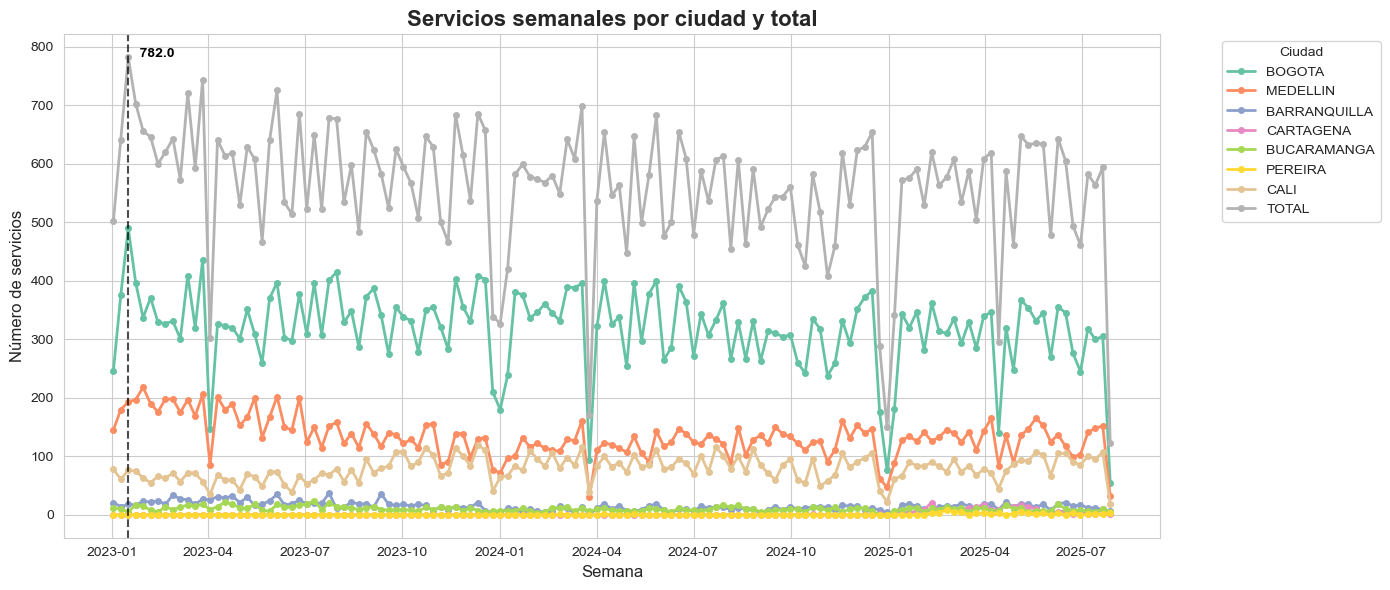

In [2]:
plot_weekly_services(labors_raw_df, valid_cities)

## Diario

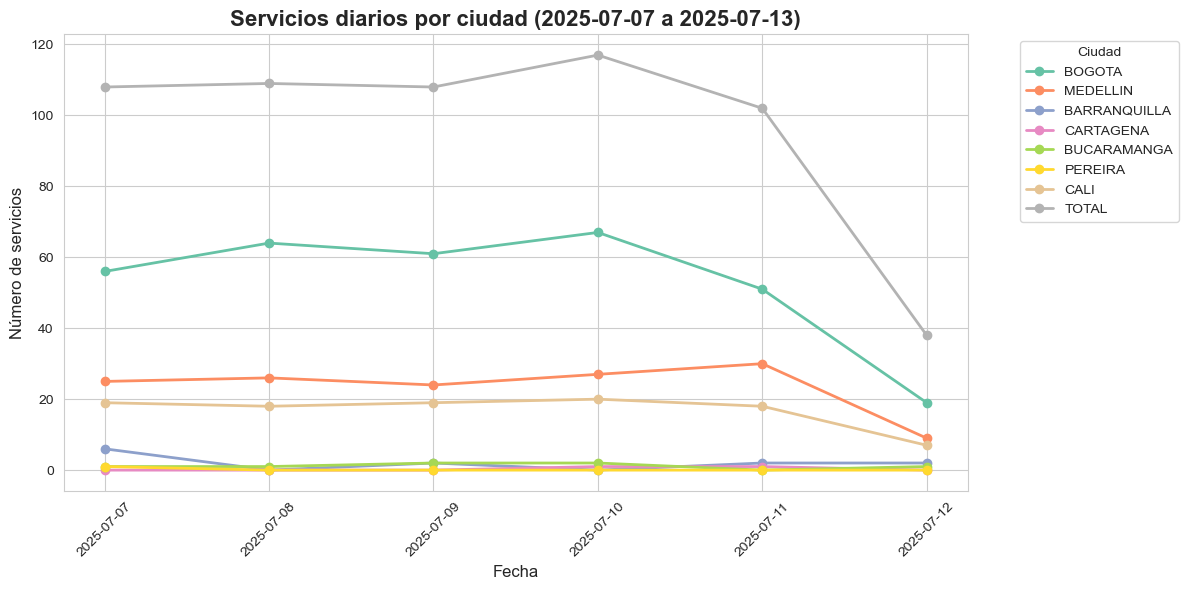

In [3]:
# df_dist = df_dist[pd.notna(df_dist['labor_start_date'])] 
plot_daily_services_week(labors_raw_df, valid_cities, start_date='2025-07-07')

# Semana artificial 08-09-25

## Generar instancia artificial

In [ ]:

# labors_filtered_df = filter_invalid_services(labors_raw_df=labors_raw_df)
labors_filtered_df = labors_raw_df

In [4]:
top7_df = top_service_days(labors_filtered_df, city_col="city", date_col="labor_start_date", 
                           top_n=7, starting_year=2025)
labors_art_df, mapping_df = create_artificial_week(labors_filtered_df, top7_df)

labors_art_df.to_csv(f'{data_path}/data_clean/artif_col_inst/{instance}/labors_{instance}_df.csv',index=False)
mapping_df.to_csv(f'{data_path}/data_clean/artif_col_inst/{instance}/mapping_art_.csv',index=False)

## Explorar instancia artificial

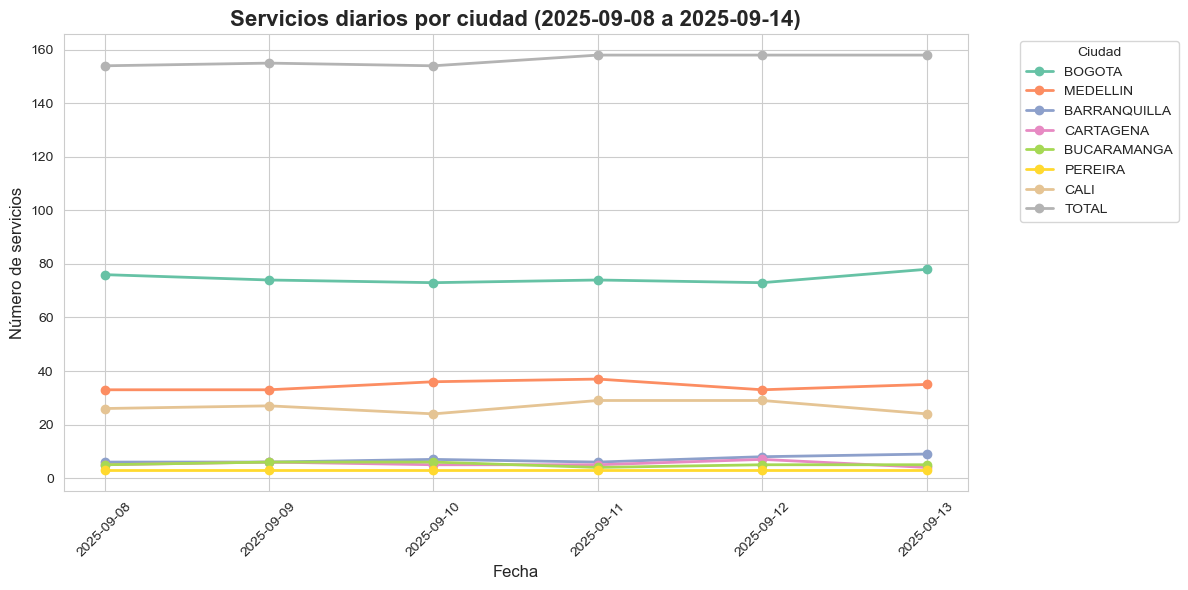

In [6]:
plot_daily_services_week(labors_art_df, valid_cities, start_date='2025-09-08')